In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('./train.csv')

In [3]:
df.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469803,6.476038e+05
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.073573,3.321452e+06
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.462081,9.570885e+06
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.628966,1.421501e+07
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.131236,7.627120e+05


<h1>Handle Missing value</h1>

Missing value percentage by column: 

parking_area             94.828333
parking_price            76.775000
txn_floor                26.503333
village_income_median     1.903333
dtype: float64


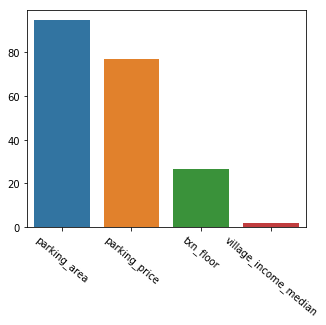

In [4]:
train_na = (df.isnull().sum() / len(df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]

print("Missing value percentage by column: \n")
print(train_na)

f, ax = plt.subplots(figsize=(5, 4))
plt.xticks(rotation='-40')
sns.barplot(x=train_na.index, y=train_na)

<h3>Remove "parking_area" due to over 94% missing value percentage</h3>

In [5]:
df = df.drop(['parking_area'], axis=1)

<h3>Fill NA value by features</h3>

In [6]:
df['parking_price'] = df['parking_price'].fillna(0)
df['village_income_median'] = df['village_income_median'].fillna(df['village_income_median'].mean())
df['txn_floor'] = df['txn_floor'].fillna(0)

<h1>Observe total_price distribution</h1>

In [7]:
from scipy.stats import norm, stats

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


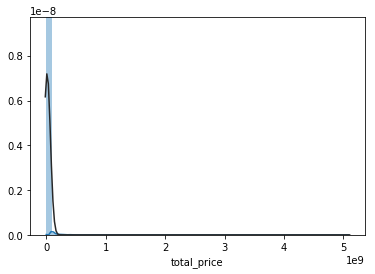

In [8]:
sns.distplot(df['total_price'] , fit=norm)

<h3>total_price's distribution is screwed right and has outlier</h3>

In [9]:
#handle screwed right
df["total_price"] = np.log1p(df["total_price"])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


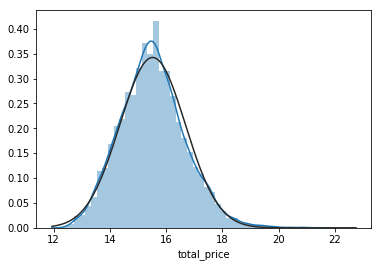

In [10]:
sns.distplot(df['total_price'] , fit=norm)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


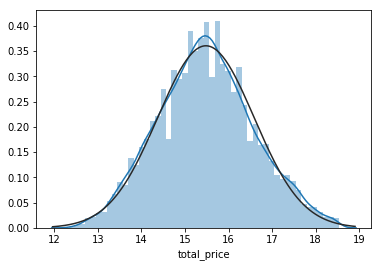

In [11]:
#handle outlier
q = df["total_price"].quantile(0.99)

test = df[df["total_price"] < q]
sns.distplot(test["total_price"], fit=norm)

<h1>Create training and testing set</h1>

In [12]:
#remove useless feature
df = df.drop(['building_id'], axis=1)

In [13]:
#splite to X, y dataframe
df_price = df['total_price']
df = df.drop(['total_price'], axis=1)

In [14]:
random_seed = 5 # set seed for same train test data split
X_train, X_test, y_train, y_test = train_test_split(df, df_price, random_state=random_seed, test_size = 0.2)

<h1>Use random search to find best parameters for lightGBM</h1>

In [10]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import r2_score

hyper_space = {'n_estimators': sp_randint(1000, 7000),
               'max_depth':  [15, 16, 17, 18, 19, 20 ,-1],
               'num_leaves': [20,30,40, 50, 60, 70,80],
               'subsample': sp_uniform(0.6, 0.4),
               'colsample_bytree': sp_uniform(0.6, 0.4)}

gbm = lgb.LGBMRegressor(objective='regression',num_leaves=250,learning_rate=0.05,n_estimators=1500)

rs = RandomizedSearchCV(gbm, hyper_space, n_iter=60, scoring='r2', cv=4, 
                         verbose=1, random_state=2018)
rs_results = rs.fit(X_train, y_train)
print("BEST PARAMETERS: " + str(rs_results.best_params_))
print("BEST CV SCORE: " + str(rs_results.best_score_))

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 274.6min finished


BEST PARAMETERS: {'colsample_bytree': 0.7544604487797361, 'max_depth': 17, 'n_estimators': 6843, 'num_leaves': 30, 'subsample': 0.7198181572347372}
BEST CV SCORE: 0.9682246127077425


<h3>Evaluate model by hit rate</h3>

In [42]:
import numpy as np
p = np.abs(( np.exp(y_pred) - np.exp(y_test) )/ np.exp(y_test))
np.sum((p <=.1))/len(y_pred)

0.5446666666666666

<h1>Predict test value for submission</h1>

In [36]:
test_df = pd.read_csv('./test.csv')
test_df = test_df.drop(['building_id','parking_area'], axis=1)

<h3>Fit the shape of training data</h3>

In [5]:
test_df = test_df.drop(['parking_area'], axis=1)

In [6]:
test_df['parking_price'] = test_df['parking_price'].fillna(0)
test_df['village_income_median'] = test_df['village_income_median'].fillna(test_df['village_income_median'].mean())
test_df['txn_floor'] = test_df['txn_floor'].fillna(0)

<h3>Predict...</h3>

In [ ]:
# Predict value
y_sub_GBM = rs.predict(test_df)
# Get inverse of log value
y_sub_GBM = np.exp(y_answer_GBM)